<a href="https://colab.research.google.com/github/sidharth-red/MCMC/blob/main/PTMCMC_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install emcee

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 659.3 kB/s eta 0:00:00


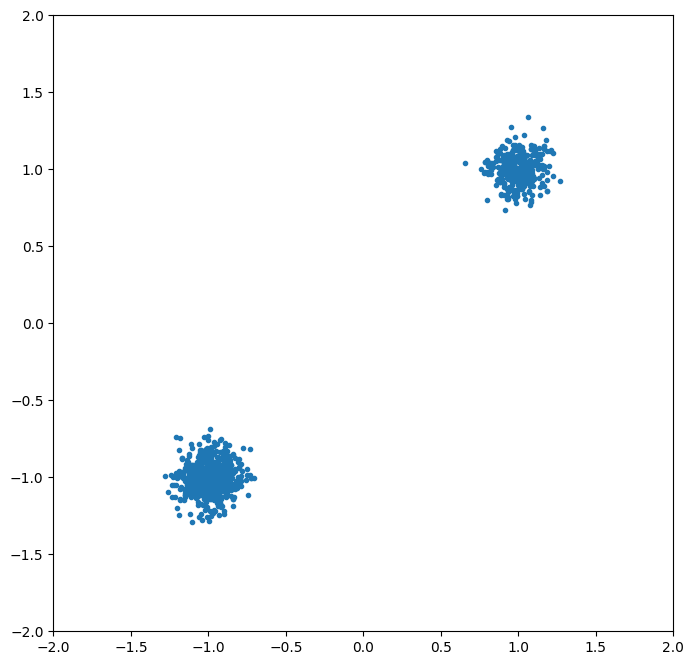

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
tfd = tfp.distributions

dtype = np.float32

target = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=[0.5, 0.5]),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=[[-1., -1], [1., 1.]],
        scale_diag=0.1*tf.ones([2, 2])))

inverse_temperatures = 0.2**tf.range(4, dtype=dtype)

# step_size must broadcast with all batch and event dimensions of target.
# Here, this means it must broadcast with:
#  [len(inverse_temperatures)] + target.event_shape
step_size = 0.075 / tf.reshape(tf.sqrt(inverse_temperatures), shape=(4, 1))

def make_kernel_fn(target_log_prob_fn):
  return tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=target_log_prob_fn,
      step_size=step_size, num_leapfrog_steps=3)

remc = tfp.mcmc.ReplicaExchangeMC(
    target_log_prob_fn=target.log_prob,
    inverse_temperatures=inverse_temperatures,
    make_kernel_fn=make_kernel_fn)

samples = tfp.mcmc.sample_chain(
    num_results=1000,
    # Start near the [1, 1] mode. Standard HMC would get stuck there.
    current_state=tf.ones(2, dtype=dtype),
    kernel=remc,
    trace_fn=None,
    num_burnin_steps=500)

plt.figure(figsize=(8, 8))
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.plot(samples[:, 0], samples[:, 1], '.')
plt.show()